In [71]:
#keeps the information about the experiment

import numpy as np

class data:
    
    const = 10000 #magnetic constant
    
    flux_real = 723 #real flux we measure
    flux_min = 0 #left border
    flux_max = 1000 #right border
    flux_step = 0.01
    
    flux = 0 #the most possible flux 
    prob = 0 #the probability of the most possible flux
    
    n = round((flux_max - flux_min) / flux_step) + 1 #amount of dots
    
    t = 0 #current time delay
    t_min = (np.pi / 2) / (const * (flux_max + flux_min) / 2) #left border
    t_max = (np.pi / 2) / (const * (flux_max + flux_min) / 2) * 1024 #right border
    
    present = [] #current probability field 
    initial = [] #initial probability field
    interval = [] #fluxes field
    
    delta_flux = [] #flux error of every step
    delta_time = [] #total time delay of every step
    
    repeat = 10 #amount of repeats for a constant time delay
    
    def __init__ (self):
        data.t = data.t_min
        for i in range(data.n):
            data.present.append(1 / data.n) #uniform distribution
            data.initial.append(1 / data.n) #uniform distribution 
            data.interval.append(data.flux_min + i * data.flux_step) #fluxes field
    
    def __del__ (self):
        ...
        
    #doubles the time delay    
    
    def double_delay(self):
        data.t *= 2
        
    #calculates the average flux

    def avg(self):
        
        avg = 0
        normalization = 0
        
        for i in range(len(data.present)):
            avg += data.present[i] * data.interval[i]
            normalization += data.present[i]
        
        data.flux = avg / normalization
        data.prob = 0
        
        for i in range(len(data.present)):
            if data.present[i] > data.prob:
                data.prob = data.present[i]
        
        return data.flux
    
    #calculates the error

    def sigma(self):
    
        number = 1 / np.sqrt(2)
    
        pike_x = data.avg(self)
        pike_y = data.prob
    
        count = 0
    
        for i in range(len(data.present)):
            if data.present[i] > number * pike_y:
                count = count + 1
        
        return count * data.flux_step / 2

In [72]:
#returns the state 

import numpy as np

np.random.seed(47)

def randbin(data, f):
    phi = data.const * f * data.t
    p_0 = (np.sin(phi / 2)) ** 2
    return np.random.choice([0,1], size=(1,1), p=[p_0, 1-p_0]).reshape(1)[0]

#returns the probability of the given state depending on the given flux 

def pstate(data, x, f):
    if x == 0:
        return (np.sin(data.const * f * data.t / 2)) ** 2
    else:
        return (np.cos(data.const * f * data.t / 2)) ** 2

In [73]:
#the bayes theorem

def bayes(data):
    
    serv = 0
    for i in range(data.repeat):
        serv += randbin(data, data.flux_real)
    h = round(serv / data.repeat)
    
    normalization = 0
    
    for i in range(len(data.present)):
        data.present[i] = data.present[i] * pstate(data, h, data.flux_min + i * data.flux_step)
        normalization += data.present[i]
    
    for i in range(len(data.present)):
        data.present[i] /= normalization

In [74]:
#graphics

import matplotlib.pyplot as plt
import numpy as np

def draw_distribution(data):
    
    plt.rcParams['figure.figsize'] = [10, 10]
    
    plt.plot(data.interval, data.present, 'o', color = 'b', label = 'current step')
    plt.plot(data.interval, data.initial, 'o', color = 'r', label = 'initial')
    
    plt.title('distribution', fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major', color='k', linewidth=1)
    plt.grid(which='minor', color='k', linestyle=':')
    
    plt.show()

def draw_scaling(data):
    
    heiz = np.array([])
    shot = np.array([])
    
    dflux = np.array(data.delta_flux)
    dtime = np.array(data.delta_time)
    
    for i in range(len(dtime)):
        heiz = np.append(heiz, np.log2(1 / dtime[i]))
        shot = np.append(shot, np.log2(1 / np.sqrt(dtime[i])))     
    
    for i in range(len(dtime)):
        dflux[i] = np.log2(dflux[i])
        dtime[i] = np.log2(dtime[i])
    
    plt.rcParams['figure.figsize'] = [10,10]
    
    A3 = np.vstack([dtime, np.ones(len(dtime))]).T
    m3, c3 = np.linalg.lstsq(A3, dflux, rcond=None)[0]
    plt.plot(dtime, dflux, 'o', color = 'k', markersize = 5)
    plt.plot(dtime, m3*dtime + c3, 'c', label = 'experiment')
    
    A1 = np.vstack([dtime, np.ones(len(dtime))]).T
    m1, c1 = np.linalg.lstsq(A1, heiz, rcond=None)[0]
    #plt.plot(dtime, heiz, 'o', color = 'k', markersize = 5)
    plt.plot(dtime, m1*dtime + c3, 'g', label='heizenberg')
    
    A2 = np.vstack([dtime, np.ones(len(shot))]).T
    m2, c2 = np.linalg.lstsq(A2, shot, rcond=None)[0]
    #plt.plot(dtime, shot, 'o', color = 'k', markersize = 5)
    plt.plot(dtime, m2*dtime + c3, 'g', label = 'shot noise')
    
    plt.title('scaling', fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major', color='k', linewidth=1)
    plt.grid(which='minor', color='k', linestyle=':')
    
    print('slope:', m3,'intercept:', c3)
    
    plt.show()

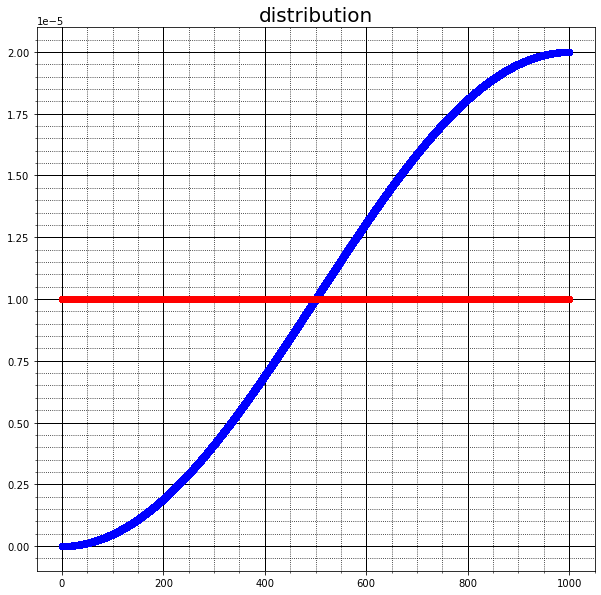

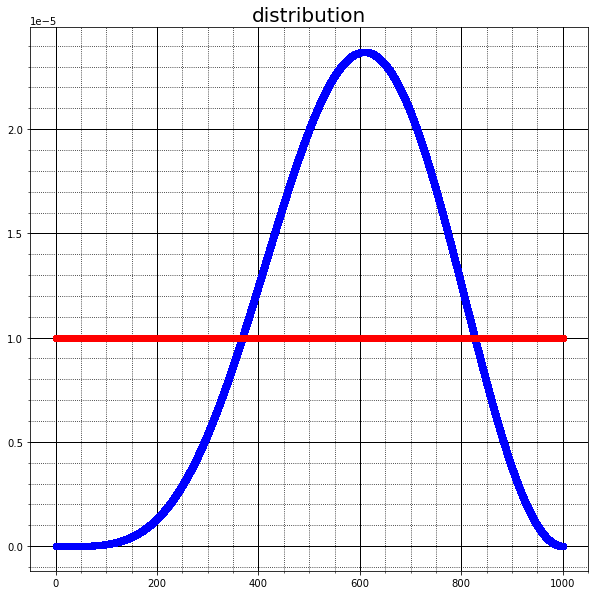

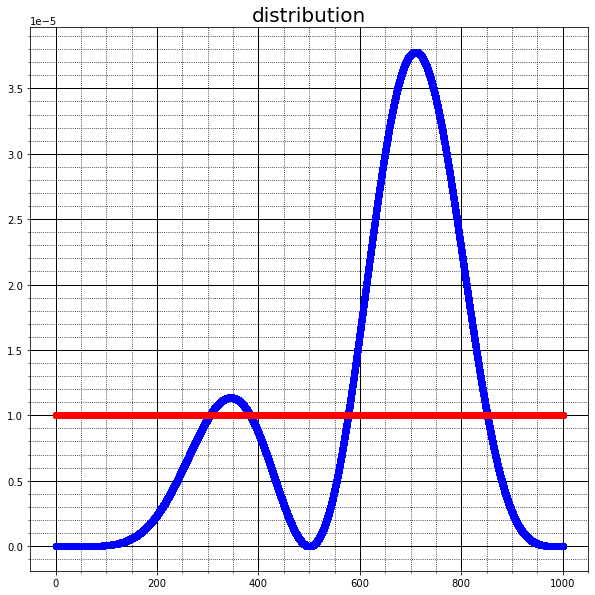

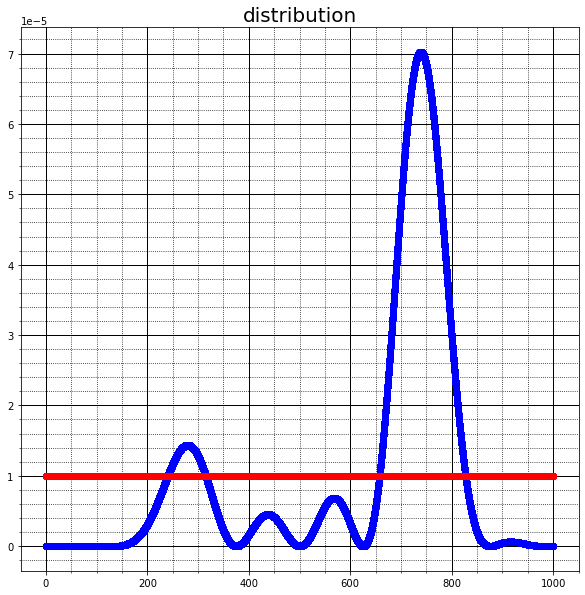

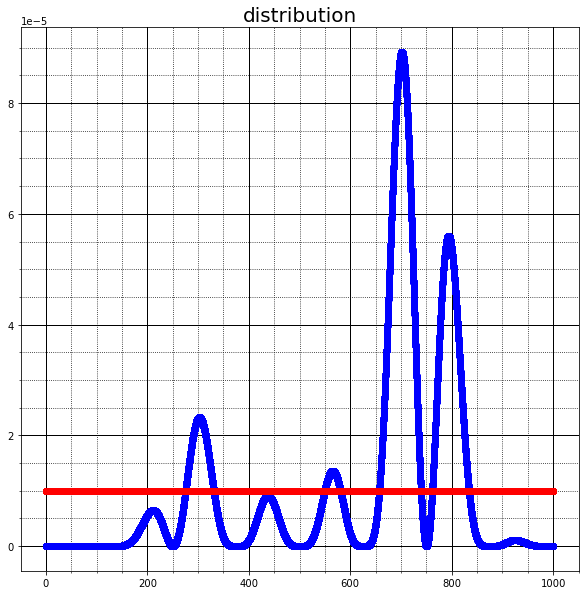

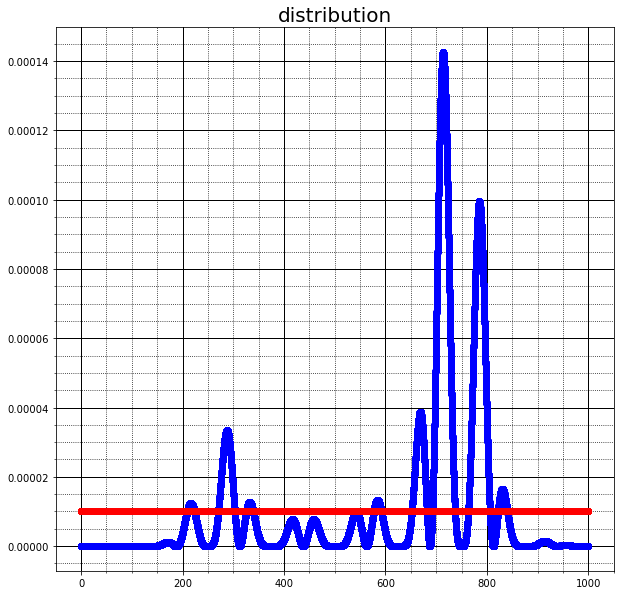

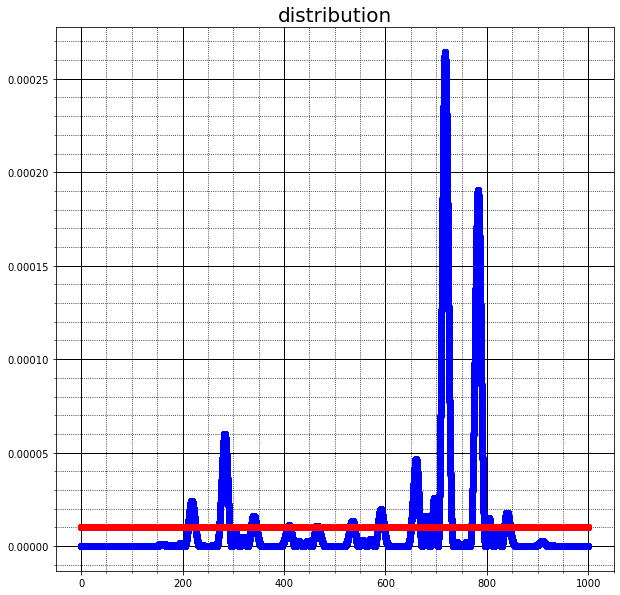

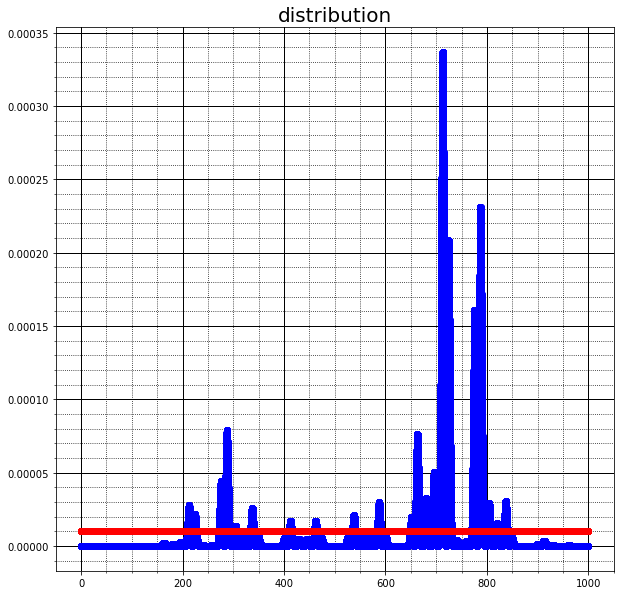

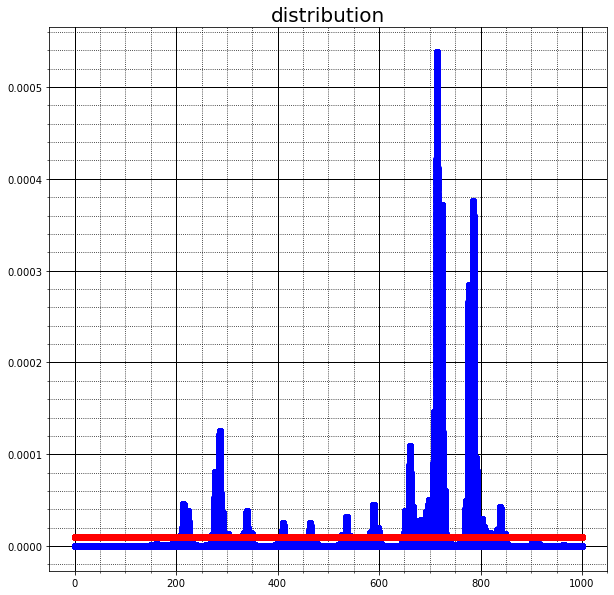

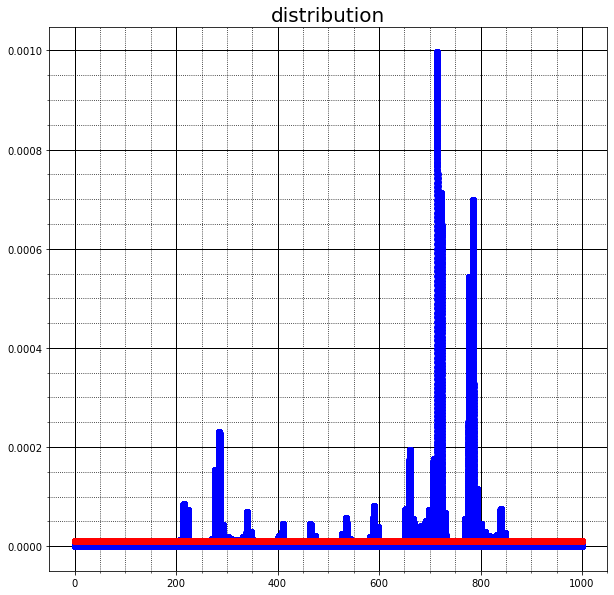

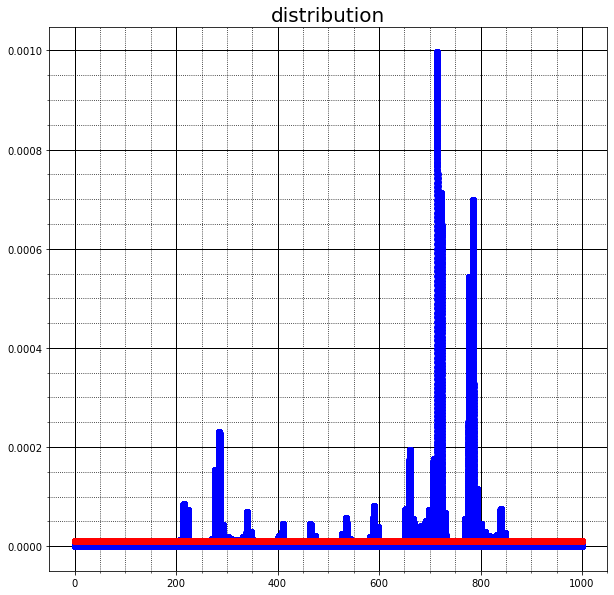

calculated flux is 652.3946029060817 +- 0.71 ( 0.10882983961506057 %)
and the real flux was 723 . mistake: 9.76561508906201 %
slope: -0.8662891653512623 intercept: -10.396601453081217


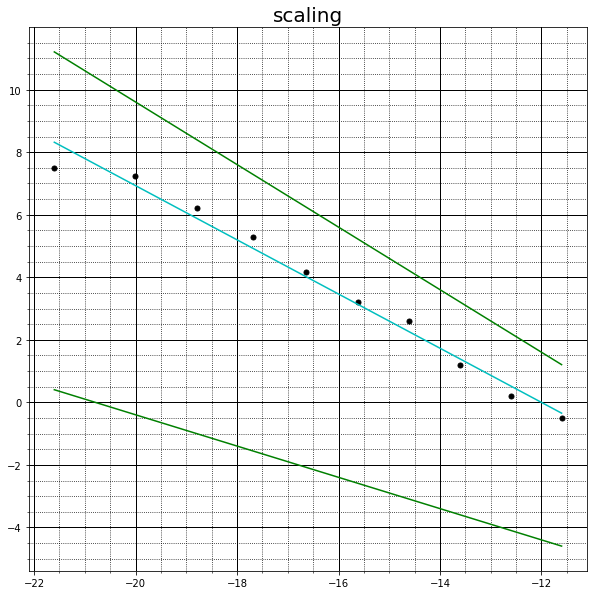

In [75]:
#main

import numpy as np

experiment = data()

for i in range(int(np.log2(experiment.t_max/ experiment.t_min))):
    
    bayes(experiment) #one step of bayes theorem    
    
    err = experiment.sigma() #calculates and saves the error
        
    experiment.delta_flux.append(err) #saves the error
    
    if i == 0:
        experiment.delta_time.append(experiment.t)
    else:
        experiment.delta_time.append(experiment.t + experiment.delta_time[i-1])
        
    draw_distribution(experiment)
        
    experiment.double_delay() #doubles the time
    
draw_distribution(experiment)    

print('calculated flux is', experiment.flux, '+-', err, '(', err / experiment.flux * 100, '%)')

print('and the real flux was', experiment.flux_real, '. mistake:',
      abs(experiment.flux - experiment.flux_real) / experiment.flux_real * 100, '%')
    
draw_scaling(experiment)

del experiment